# Single Ring Neuron Experiment

## Imports

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt

## Equations

### Output Transform Function (Sigmoid)
$$u_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = 10; \mu = 0.2$$

In [10]:
def transform(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### Activity Equation
$$\frac{dv_i}{dt}=\frac{1}{\tau}(-qv_i+i_1-\alpha z_i)$$ 
$$\tau = 1.0; q=0.5; \alpha = 0.2$$

### Deactivation Equation
$$\frac{dz_i}{dt}=-az_i+\frac{u_i}{c_k}$$
$$a=0.2$$

In [11]:
t = np.linspace(0, 20, 2000)
y0 = [0.0, 0.0]

def doodle(t, state, p):
    return [
        (1 / p['tau']) * ((-1 * p['q'] * state[0]) + p['i_1'] - (p['alpha'] * state[1])),
        (-1 * p['a'] * state[1]) + (transform(state[0], p['beta'], p['mu']) / p['c_k'])
    ]

## Hyperparameter Tuning

Exploring effects of $i_1$ and $c_k$

Text(0.5, 1.0, 'Single Ring Neuron Dynamics with Baseline Parameters\ntau=1p0 - q=0p5 - i_1=0p2 - alpha=0p2 - a=0p2 - c_k=2p0 - beta=10p0 - mu=0p2')

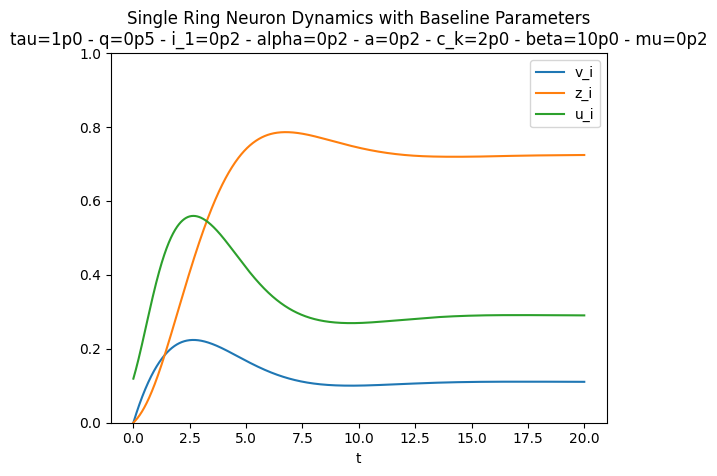

In [12]:
BASELINE_PARAMS = {
    'tau': 1.0,
    'q': 0.5,
    'i_1': 0.2,
    'alpha': 0.2,
    'a': 0.2,
    'c_k': 2.0,
    'beta': 10.0,
    'mu': 0.2
}
result = solve_ivp(fun=lambda t, state: doodle(t, state, BASELINE_PARAMS), t_span=(0,20), t_eval=t, y0=y0)
fig,ax = plt.subplots()
ax.plot(t,result.y[0].T,label='v_i')
ax.plot(t,result.y[1].T,label='z_i')
ax.plot(t,transform(result.y[0], BASELINE_PARAMS['beta'], BASELINE_PARAMS['mu']).T,label='u_i')
ax.legend()
ax.set_ylim([0, 1])
ax.set_xlabel('t')
ax.set_title(f"Single Ring Neuron Dynamics with Baseline Parameters\ntau={BASELINE_PARAMS['tau']}|q={BASELINE_PARAMS['q']}|i_1={BASELINE_PARAMS['i_1']}|alpha={BASELINE_PARAMS['alpha']}|a={BASELINE_PARAMS['a']}|c_k={BASELINE_PARAMS['c_k']}|beta={BASELINE_PARAMS['beta']}|mu={BASELINE_PARAMS['mu']}".replace('.','p').replace('|',' - '))

In [13]:
for i_1 in [0.0, 0.2, 0.5, 0.8, 1.0, 2.0]:
    for c_k in [0.1, 0.2, 0.5, 0.8, 1.0, 2.0]:
        params = {
            'tau': 1.0,
            'q': 0.5,
            'i_1': i_1,
            'alpha': 0.2,
            'a': 0.2,
            'c_k': c_k,
            'beta': 10.0,
            'mu': 0.2
        }
        result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(0,20), t_eval=t, y0=y0)
        fig,ax = plt.subplots()
        ax.plot(t,result.y[0].T,label='v_i')
        ax.plot(t,result.y[1].T,label='z_i')
        ax.plot(t,transform(result.y[0], params['beta'], params['mu']).T,label='u_i')
        ax.legend()
        ax.set_ylim([0, 1])
        ax.set_xlabel('t')
        ax.set_title(f"tau={params['tau']}|q={params['q']}|i_1={params['i_1']}|alpha={params['alpha']}|a={params['a']}|c_k={params['c_k']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
        plt.tight_layout()
        plt.savefig(f"plots\\tau={params['tau']}|q={params['q']}|i_1={params['i_1']}|alpha={params['alpha']}|a={params['a']}|c_k={params['c_k']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
        plt.close()